In [1]:
import cv2
import torch
import numpy as np
from PIL import Image

from diffusers.utils import load_image
from diffusers.models import ControlNetModel
from diffusers.pipelines.controlnet.multicontrolnet import MultiControlNetModel

from insightface.app import FaceAnalysis
from pipeline_stable_diffusion_xl_instantid_full import StableDiffusionXLInstantIDPipeline, draw_kps

from controlnet_aux import MidasDetector

def convert_from_image_to_cv2(img: Image) -> np.ndarray:
    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

def resize_img(input_image, max_side=1280, min_side=1024, size=None, 
               pad_to_max_side=False, mode=Image.BILINEAR, base_pixel_number=64):

    w, h = input_image.size
    if size is not None:
        w_resize_new, h_resize_new = size
    else:
        ratio = min_side / min(h, w)
        w, h = round(ratio*w), round(ratio*h)
        ratio = max_side / max(h, w)
        input_image = input_image.resize([round(ratio*w), round(ratio*h)], mode)
        w_resize_new = (round(ratio * w) // base_pixel_number) * base_pixel_number
        h_resize_new = (round(ratio * h) // base_pixel_number) * base_pixel_number
    input_image = input_image.resize([w_resize_new, h_resize_new], mode)

    if pad_to_max_side:
        res = np.ones([max_side, max_side, 3], dtype=np.uint8) * 255
        offset_x = (max_side - w_resize_new) // 2
        offset_y = (max_side - h_resize_new) // 2
        res[offset_y:offset_y+h_resize_new, offset_x:offset_x+w_resize_new] = np.array(input_image)
        input_image = Image.fromarray(res)
    return input_image


/home/jupyter/genai_project/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jupyter/genai_project/venv/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
/home/jupyter/genai_project/venv/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/jupyter/genai_project/venv/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry

In [2]:

# Load face encoder
app = FaceAnalysis(name='antelopev2', root='./', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))

# Path to InstantID models
face_adapter = f'./checkpoints/ip-adapter.bin'
controlnet_path = f'./checkpoints/ControlNetModel'
controlnet_depth_path = f'diffusers/controlnet-depth-sdxl-1.0-small'

# Load depth detector
midas = MidasDetector.from_pretrained("lllyasviel/Annotators")

# Load pipeline
controlnet_list = [controlnet_path, controlnet_depth_path]
controlnet_model_list = []
for controlnet_path in controlnet_list:
    controlnet = ControlNetModel.from_pretrained(controlnet_path, torch_dtype=torch.float16)
    controlnet_model_list.append(controlnet)
controlnet = MultiControlNetModel(controlnet_model_list)

base_model_path = 'SG161222/RealVisXL_V5.0'

pipe = StableDiffusionXLInstantIDPipeline.from_pretrained(
    base_model_path,
    controlnet=controlnet,
    torch_dtype=torch.float16,
)
pipe.cuda()
pipe.load_ip_adapter_instantid(face_adapter)

   

/home/jupyter/genai_project/venv/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:118: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


models antelopev2 ./
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/glintr100.onnx recognition ['None', 3, 112, 112] 127.5 127.5
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/scrfd_10g_bnkps.onnx detection [1, 3, '?', '?'] 127.5 128.0
set det-size: (640, 640)


/home/jupyter/genai_project/venv/lib/python3.10/site-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/home/jupyter/genai_project/venv/lib/python3.10/site-packages/diffusers/pipelines/controlnet/multicontrolnet.py:11: FutureWarning: `diffusers.pipelines.controlnet.multic

100%|██████████| 30/30 [00:24<00:00,  1.23it/s]


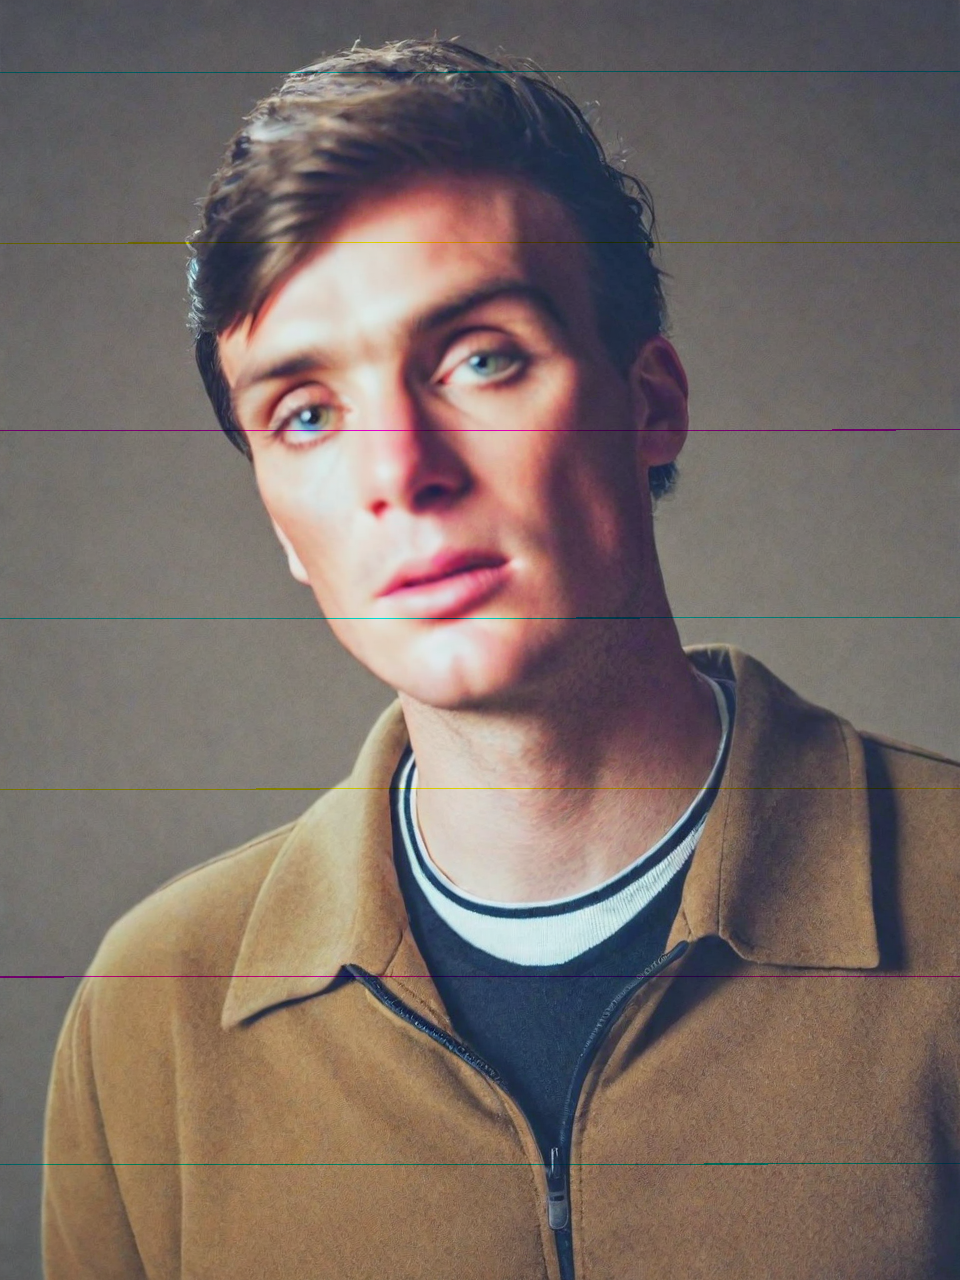

In [12]:
# Infer setting
prompt = "an analoge of a man. Super realistic photo, best quality, 85mm lens, vivid color, hyperrealistic, move light only in background, detailed face, classical suit"
n_prompt = "grain, low quality, ugly, cartoon, unrealistic, disfigured fingers, distorted face, coloring lines"

face_image = load_image("/home/jupyter/genai_project/train/instant_id_inference/InstantID/examples/references/cillian.jpg")
face_image = resize_img(face_image)

face_info = app.get(cv2.cvtColor(np.array(face_image), cv2.COLOR_RGB2BGR))
face_info = sorted(face_info, key=lambda x:(x['bbox'][2]-x['bbox'][0])*(x['bbox'][3]-x['bbox'][1]))[-1] # only use the maximum face
face_emb = face_info['embedding']

# use another reference image
pose_image = load_image("/home/jupyter/genai_project/train/instant_id_inference/InstantID/examples/poses/pose2.jpg")
pose_image = resize_img(pose_image)

face_info = app.get(cv2.cvtColor(np.array(pose_image), cv2.COLOR_RGB2BGR))
pose_image_cv2 = convert_from_image_to_cv2(pose_image)
face_info = sorted(face_info, key=lambda x:(x['bbox'][2]-x['bbox'][0])*(x['bbox'][3]-x['bbox'][1]))[-1] # only use the maximum face
face_kps = draw_kps(pose_image, face_info['kps'])

width, height = face_kps.size

# use depth control
processed_image_midas = midas(pose_image)
processed_image_midas = processed_image_midas.resize(pose_image.size)

# enhance face region
control_mask = np.zeros([height, width, 3])
x1, y1, x2, y2 = face_info["bbox"]
x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
control_mask[y1:y2, x1:x2] = 255
control_mask = Image.fromarray(control_mask.astype(np.uint8))

image = pipe(
    prompt=prompt,
    negative_prompt=n_prompt,
    image_embeds=face_emb,
    control_mask=control_mask,
    image=[face_kps, processed_image_midas],
    controlnet_conditioning_scale=[0.8,0.8],
    ip_adapter_scale=0.8,
    num_inference_steps=30,
    guidance_scale=5,
).images[0]
image.save('/home/jupyter/genai_project/output_images/instant_id/cillian.jpg')
image


In [26]:
import os


folder_path = '/home/jupyter/genai_project/output_images/instant_id/'
folds = {}
for img in os.listdir(folder_path):
    img_fld = img.split('.')[0]
    folds[folder_path+img_fld+'/'+img] = folder_path+img

# folds
for fold in folds.keys():
    os.makedirs(fold.split('.')[0], exist_ok=True)
    os.rename(folds[fold], fold)

